# Project 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exercise 1

In [2]:
# Combine the baby names by state data set into a single file
# type "C:\Users\xinra\Desktop\MLDS\422-Python\project 1\babynamesbystate\*.txt" > "C:\Users\xinra\Desktop\MLDS\422-Python\project 1\combined_baby_names.txt"

1

In [3]:
# define the class
class BabyNames:
    def __init__(self, file_loc):
        self.file =  pd.read_csv( file_loc, sep=",", header=None)
        self.file.columns = ["state", "sex", "birth_year", "name","num"]
    
    def Count(self, state="", year=""):
        # filter the dataset
        df = self.file
        if state !="":
            df = df[df['state'] == state]
        if year !="":
            df = df[df['birth_year'] == year]
        
        # return the total number of occurence
        return df["num"].sum()
    
    def Top10BabyNames (self, state="", year=""):
        # filter the dataset
        df = self.file
        if state !="":
            df = df[df['state'] == state]
        if year !="":
            df = df[df['birth_year'] == year]
        
        # find top 10 for male and female seperately
        top10_male = df[df["sex"]=="M"].sort_values(by="num", ascending = False)[:10]
        top10_female = df[df["sex"]=="F"].sort_values(by="num", ascending = False)[:10]
        
        # combine
        df_result = pd.DataFrame()
        df_result["rank"] = range(1, 11)
        df_result["Male"] = top10_male.reset_index()["name"]
        df_result["Female"] = top10_female.reset_index()["name"]
        
        return df_result
        
    def ChangeOfPopularity (self, fromYear, toYear, top):
        # merge fromyear and toyear dataframe
        df = self.file
        df_fromyear = df[df["birth_year"]==fromYear]
        df_toyear = df[df["birth_year"]==toYear]
        df_result = pd.merge(pd.DataFrame(df_fromyear.groupby("name")["num"].sum()),pd.DataFrame(df_toyear.groupby("name")["num"].sum()),left_index=True,right_index=True, how="outer")
        df_result = df_result.fillna(0)
        # calculate change in popularity
        df_result["popularity_after"] = df_result["num_y"]/df_result["num_y"].sum()
        df_result["popularity_before"] = df_result["num_x"]/df_result["num_x"].sum()
        df_result["change_pop"] = df_result["popularity_after"]-df_result["popularity_before"]
        
        # increase
        df_increase = df_result[df_result["change_pop"]>0].sort_values(by="change_pop",ascending = False).reset_index()[["name","change_pop"]]
        print("The names with increased popularity are:")
        print(df_increase.head(top))
        
        # decrease
        df_decrease = df_result[df_result["change_pop"]<0].sort_values(by="change_pop",ascending = True).reset_index()[["name","change_pop"]]
        print("The names with decreased popularity are:")
        print(df_decrease.head(top))
        
        # same
        df_same = df_result[df_result["change_pop"]==0].reset_index()[["name","change_pop"]]
        if len(df_same) >0:
            print("The names with same popularity are:")
            print(df_same)
        else:
            print("There is no name with same popularity")
    
    def Top5NamesPerYear(self, year, sex=""):
        # filter the dataset
        df = self.file
        df = df[df["birth_year"]==year]
        if sex !="":
            df = df[df['sex'] == sex]
            
        # sort and group
        df = df.groupby(['state', 'name'])['num'].sum().reset_index() # in case name for both M and F 
        df = df.sort_values(by=["state","num"], ascending=[True,False])[["state","name","num"]]
        df = df.groupby("state").head(5)
        
        # edit format
        result_data = {
            'State': [],
            'Rank 1 Name': [],
            'Rank 1 Count': [],
            'Rank 2 Name': [],
            'Rank 2 Count': [],
            'Rank 3 Name': [],
            'Rank 3 Count': [],
            'Rank 4 Name': [],
            'Rank 4 Count': [],
            'Rank 5 Name': [],
            'Rank 5 Count': []
        }

        current_state = ""
        rank = 0

        for _, row in df.iterrows():
            state = row['state']
            if state != current_state:
                rank = 0
                current_state = state
                result_data['State'].append(state)

            rank += 1
            result_data[f'Rank {rank} Name'].append(row['name'])
            result_data[f'Rank {rank} Count'].append(row['num'])

        result_df = pd.DataFrame.from_dict(result_data, orient='index')
        result_df =  result_df.T
        
        gender = "Female" if sex == "F" else "Male"
        title = f"Top Five {gender} Names for Births in {year}"
        styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "110%"),
                              ("color", 'black')])]
        result_df = result_df.style.set_caption(title).set_table_styles(styles)
        
        return result_df
        
    def NamePopularityPlot(self, name, yearRange, state, sex):
        # filter data
        df = self.file
        df = df[df["state"]==state]
        if sex !="":
            df = df[df['sex'] == sex]
        df = df[(df["birth_year"]>= yearRange[0]) & (df["birth_year"]<= yearRange[1])]
            
        # calculate popularity
        df["popularity"] =  df.groupby('birth_year')['num'].transform(lambda x: x / x.sum())
        df = df[df["name"] == name]
        
        # plot
        plt.figure(figsize=(10, 6))
        plt.plot(df["birth_year"], df["popularity"])
        plt.xlabel("Year")
        plt.ylabel("Name Popularity")
        plt.title(f"{name} Popularity Over Years")
        plt.grid(True)
        plt.show()
    
    def NameFlip(self, n=10):
        # find the n names which have largest change over years
        df = self.file
        df = pd.DataFrame(df.groupby(["name","birth_year","sex"])["num"].sum()).reset_index()
        df["prop"] = df.groupby(["name","birth_year"])["num"].transform(lambda x: x / x.sum()) # slow
        df = df[df["sex"]=="F"]
        df_diff = pd.DataFrame(df.groupby("name")["prop"].max()-df.groupby("name")["prop"].min())
        df_diff = df_diff.sort_values(by="prop", ascending = False).head(n)
        
        # plot
        name_list = df_diff.index.to_list()
        df = df[df["name"].isin(name_list)][["name","birth_year","prop"]].reset_index()
        plt.figure(figsize=(10, 6))

        for name, group in df.groupby('name'):
            plt.plot(group['birth_year'], group['prop'], label=name)

        plt.xlabel('Year')
        plt.ylabel('Female Percentage')
        plt.title('Female Popularity Over the Years')
        plt.legend()
        plt.grid(True)
        plt.show()


In [4]:
# initiate
baby_names = BabyNames("combined_baby_names.txt")

In [5]:
# count total number of occurence
baby_names.Count("IL",2015)

124693

In [6]:
# top 10 baby names
baby_names.Top10BabyNames("IL",2015)

,rank,Male,Female
0,1,Noah,Olivia
1,2,Liam,Emma
2,3,Alexander,Sophia
3,4,Jacob,Mia
4,5,Michael,Isabella
5,6,Benjamin,Ava
6,7,William,Sofia
7,8,Daniel,Abigail
8,9,Mason,Amelia
9,10,James,Charlotte


In [7]:
# change of popularity
baby_names.ChangeOfPopularity (fromYear=2014, toYear=2015, top=10)

The names with increased popularity are:
        name  change_pop
0     Oliver    0.000714
1      Alexa    0.000575
2        Mia    0.000456
3      Hazel    0.000447
4    Grayson    0.000438
5     Matteo    0.000433
6  Charlotte    0.000418
7      Mateo    0.000410
8    Lincoln    0.000388
9   Scarlett    0.000364
The names with decreased popularity are:
        name  change_pop
0     Jayden   -0.000488
1       Jase   -0.000461
2   Isabella   -0.000457
3     Sophia   -0.000369
4     Joshua   -0.000343
5  Annabelle   -0.000343
6     Andrew   -0.000326
7     Peyton   -0.000321
8     Alexis   -0.000317
9    Michael   -0.000311
There is no name with same popularity


In [8]:
# Top 5 Names Per Year
baby_names.Top5NamesPerYear(2015, "F")

,State,Rank 1 Name,Rank 1 Count,Rank 2 Name,Rank 2 Count,Rank 3 Name,Rank 3 Count,Rank 4 Name,Rank 4 Count,Rank 5 Name,Rank 5 Count
0,AK,Olivia,56,Emma,49,Aurora,46,Ava,41,Amelia,39
1,AL,Ava,298,Emma,287,Olivia,260,Harper,214,Elizabeth,187
2,AR,Emma,214,Olivia,172,Ava,169,Isabella,136,Harper,121
3,AZ,Sophia,476,Mia,465,Emma,453,Olivia,421,Isabella,388
4,CA,Sophia,2956,Mia,2866,Emma,2722,Olivia,2530,Isabella,2408
5,CO,Emma,355,Olivia,348,Mia,254,Evelyn,251,Sophia,249
6,CT,Sophia,217,Emma,203,Olivia,202,Isabella,187,Ava,184
7,DC,Genesis,50,Ava,47,Charlotte,47,Sofia,45,Emma,41
8,DE,Ava,69,Olivia,59,Sophia,57,Abigail,48,Emma,44
9,FL,Isabella,1385,Emma,1225,Sophia,1179,Olivia,1158,Mia,1033


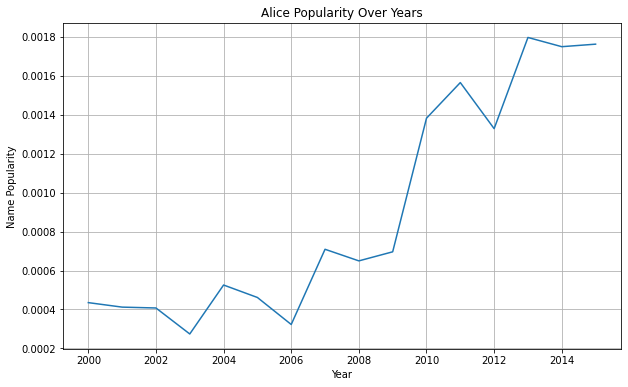

In [9]:
# plot name popularity
baby_names.NamePopularityPlot("Alice", (2000,2015), "IL", "F")

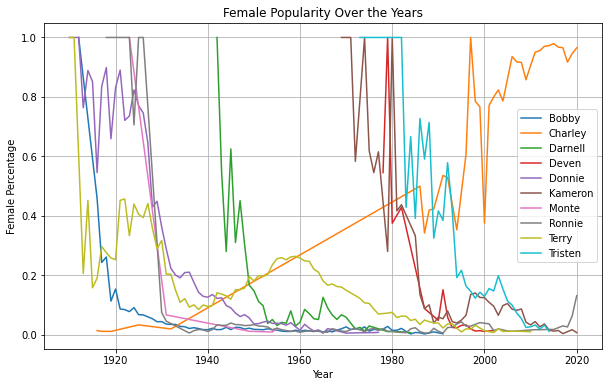

In [10]:
# name flip
baby_names.NameFlip(10)

2

We are trying to find the change of the number of our names (Grace and Sissi) during the years 

In [11]:
# read data
df = pd.read_csv("combined_baby_names.txt", sep=",", header=None)
df.columns = ["state", "sex", "birth_year", "name","num"]

Text(0.5, 1.0, 'Grace')

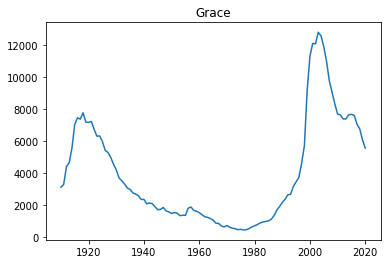

In [12]:
df1 = df[df['name'] == 'Grace'].groupby('birth_year').sum('num').reset_index()
plt.plot(df1['birth_year'],df1['num'])
plt.title("Grace")

Text(0.5, 1.0, 'Sissi')

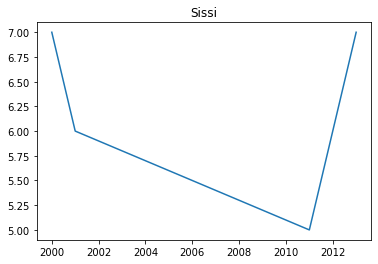

In [13]:
df2 = df[df['name'] == 'Sissi'].groupby('birth_year').sum('num').reset_index()
plt.plot(df2['birth_year'],df2['num'])
plt.title("Sissi")

In general, the name Grace is much more popular than the name Sissi. Their trand tend to be U-shaped. 

## Exercise 2

1

In [14]:
# import data
data = pd.read_csv("exams.csv")
data

,id,Name,Quizzes,Projects,Exams
0,ID1,James,43,51,55
1,ID2,Josephine,76,84,87
2,ID3,Art,89,94,92
3,ID4,Lenna,70,67,64
4,ID5,Donette,63,59,58
...,...,...,...,...,...
95,ID96,Carma,64,59,62
96,ID97,Malinda,66,62,55
97,ID98,Natalie,95,85,91
98,ID99,Lisha,69,67,55


2

In [15]:
# calculate final score
data["Final"] = 0.3*data["Quizzes"] + 0.3*data["Projects"] + 0.4*data["Exams"]
# find outlier
data_outlier = data[ (data["Final"]<= (data["Final"].mean()-2*data["Final"].std())) | (data["Final"]>= (data["Final"].mean()+2*data["Final"].std()))]
data_outlier

,id,Name,Quizzes,Projects,Exams,Final
6,ID7,Mitsue,41,43,34,38.8
33,ID34,Albina,21,41,33,31.8
41,ID42,Dyan,99,100,100,99.7
45,ID46,Fatima,93,100,100,97.9
60,ID61,Blondell,37,28,32,32.3


3

In [16]:
# calculate box plot parameters
final_min = data["Final"].min()
final_max = data["Final"].max()
final_median = data["Final"].median()
final_Q1 = data["Final"].quantile(0.25)
final_Q3 = data["Final"].quantile(0.75)

print("min:",final_min,",Q1:",final_Q1,",median:",final_median,",Q3:",final_Q3,",max:",final_max)

min: 31.799999999999997 ,Q1: 60.325 ,median: 68.65 ,Q3: 80.25 ,max: 99.7


4

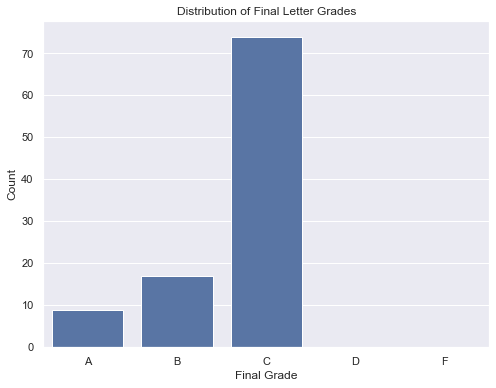

In [17]:
# calculate grade
grading_intervals = [0, 10, 20, 80, 90, 100]
grading_letters = ['F', 'D', 'C', 'B', 'A']
data["Grade"] = pd.cut(data["Final"], bins=grading_intervals, labels=grading_letters, include_lowest=True)

# plot
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="Grade", order=['A', 'B', 'C', 'D', 'F'])
plt.xlabel("Final Grade")
plt.ylabel("Count")
plt.title("Distribution of Final Letter Grades")
plt.show()

I choose countplot for the visualization, with y-axis of counts and x-axis as grade. Because the final grade is categorical. 

5

Finding 1

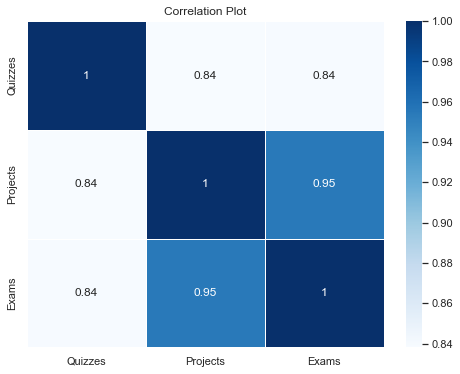

In [18]:
# fidn the correlations between quiz, project, and exam
correlation_matrix = data[["Quizzes","Projects","Exams"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=.5)
plt.title('Correlation Plot')
plt.show()

We can find that the performances in quiz, project, and exam are highly-correlated.

Finding 2

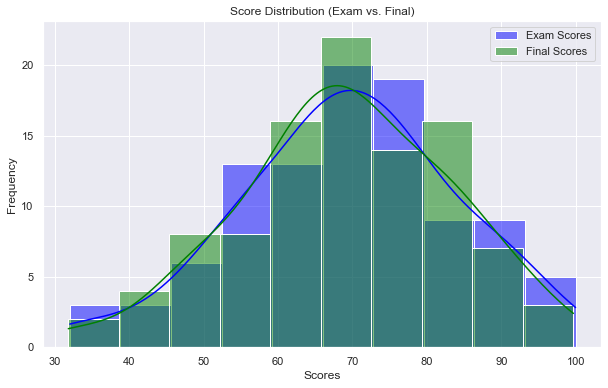

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data['Exams'], bins=10, color='blue', label='Exam Scores', kde=True)
# Create a histogram for final scores using Seaborn
sns.histplot(data=data['Final'], bins=10, color='green', label='Final Scores', kde=True)
# Add labels and legend
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
# Add a title
plt.title('Score Distribution (Exam vs. Final)')
# Show the plot
plt.show()

It seems like the exam scores are more spreading out than final scores, but in the distribution line, the both are generally the same. The mode for Final Scores are lower.